## Fulla Balanced Dataset + extra NDVI 

Here we calculate errors with various classical methods: 

Data: Sentinel-1 + Sentinel-2 + Engineered RGB features from Sentinel-2 +(my extra NDVI column)

Giacomo's balanced dataset


In [7]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [8]:
data = np.load('features_balanced.npy')

# load the numpy array into a pandas dataframe
df = pd.DataFrame(data)

df.head()
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.00000,76327.000000,...,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000,76327.000000
mean,44.336984,62.019796,64.366188,94.254314,149.797057,166.498775,169.200021,159.637664,119.21345,141.084125,...,0.788817,3.777549,-0.000943,0.710352,0.711491,4.193732,-0.003760,0.782030,0.770959,1.521856
std,29.231185,31.787207,45.092138,37.927251,40.427718,46.945837,52.515519,53.949442,63.78747,38.574664,...,10.132925,6.523826,6.612521,11.263738,11.250183,9.990991,7.565762,13.734007,13.587742,4.572153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-189.000000,-55.000000,-164.000000,-172.000000,-190.000000,-81.000000,-227.000000,-189.000000,-176.000000,-27.958036
25%,19.000000,35.000000,23.000000,62.000000,130.000000,140.000000,137.000000,121.000000,58.00000,121.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.000000,56.000000,53.000000,92.000000,151.000000,168.000000,171.000000,160.000000,115.00000,141.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,65.000000,83.000000,99.000000,121.000000,173.000000,198.000000,207.000000,201.000000,175.00000,162.000000,...,1.000000,7.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,1.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,...,204.000000,86.000000,154.000000,171.000000,177.000000,97.000000,163.000000,189.000000,152.000000,136.836212


In [9]:
# extract the last column as a numpy array
y = df.iloc[:, -1].values
print('Here is the shape of y', y.shape)

# extract all other columns as a numpy array
X = df.iloc[:, :-1].values


# print the shape of the new X array
print('Here is the shape of X:', X.shape)

Here is the shape of y (76327,)
Here is the shape of X: (76327, 23)


In [10]:
# Define the positions of the red and near-infrared bands in the array
red_band_index = 2
nir_band_index = 6

# Extract the red and near-infrared bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]

# Calculate NDVI and normalize
ndvi = np.zeros_like(nir_band)
mask = (nir_band + red_band) != 0
ndvi[mask] = (nir_band[mask] - red_band[mask]) / (nir_band[mask] + red_band[mask])
ndvi = np.clip(ndvi, -1, 1) # clip values outside [-1, 1] range
ndvi = (ndvi + 1) / 2 # rescale to [0, 1] range

# Add the NDVI feature to the array
X_with_ndvi = np.insert(X, -1, ndvi, axis=1)

X=X_with_ndvi 

print(X.shape)

(76327, 24)


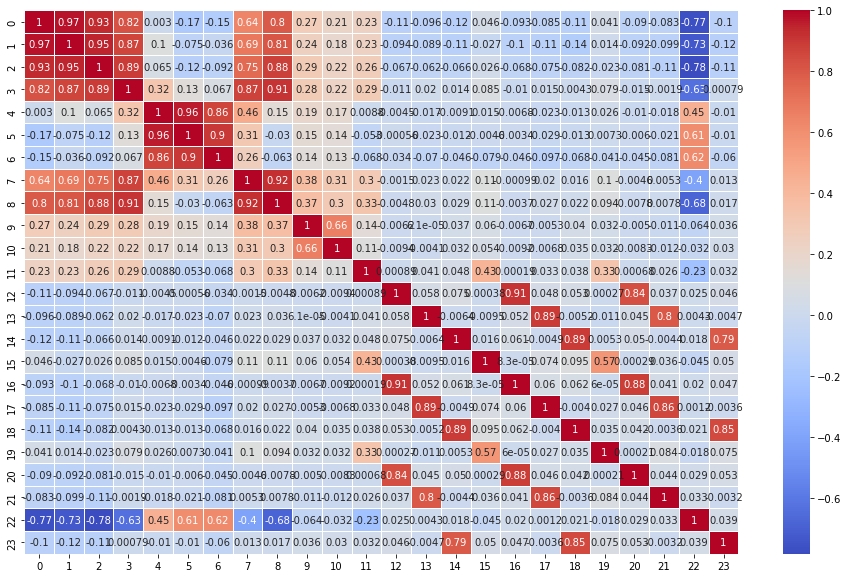

In [11]:
### Visualize correlations between columns of X 
import seaborn as sns
# create a correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# create a larger plot
fig, ax = plt.subplots(figsize=(16, 10))

# create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

# show plot
plt.show()

In [12]:
##### Runs various models on X and y prepared above 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# scale X using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize the models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Train the models on the training data
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Evaluate the models using mean squared error and R-squared
print("Linear Regression:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_lr)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_lr)))
print()

print("Decision Tree:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_dt)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_dt)))
print()

print("Random Forest:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
print()

print("Gradient Boosting:")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_gb)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_gb)))
print()


Linear Regression:
Mean Squared Error: 17.18
R-squared: 0.11

Decision Tree:
Mean Squared Error: 40.20
R-squared: -1.08

Random Forest:
Mean Squared Error: 18.03
R-squared: 0.07

Gradient Boosting:
Mean Squared Error: 17.27
R-squared: 0.11



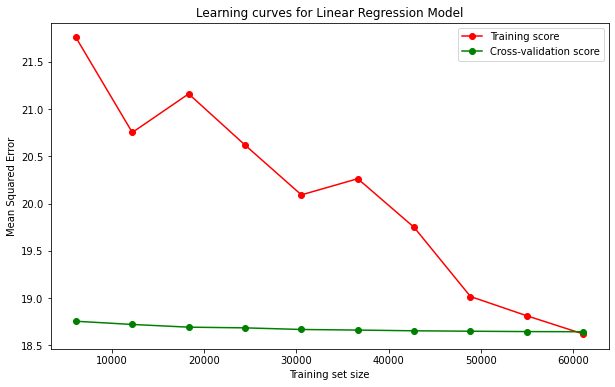

In [13]:
### Learning Curve for the regression model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

# Create an instance of the Linear Regression model
lr_model = LinearRegression()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Linear Regression model
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Linear Regression Model')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.show()


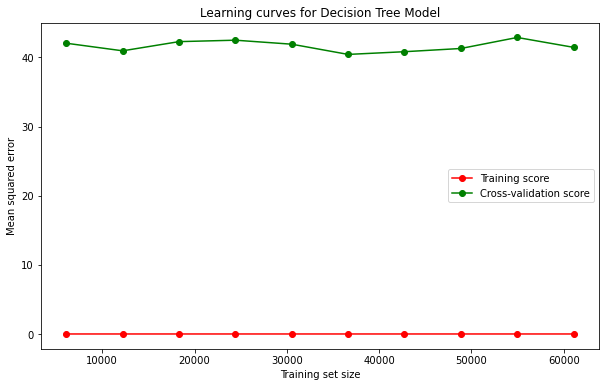

In [14]:
# Learning curve for the Decision Tree model 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve

# Convert y to a 1d array using ravel()
y = np.ravel(y)

# Create an instance of the Decision Tree model
tree_model = DecisionTreeRegressor()

# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Decision Tree model
train_sizes, train_scores, test_scores = learning_curve(tree_model, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error')

# Convert the negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning curves for Decision Tree Model')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()


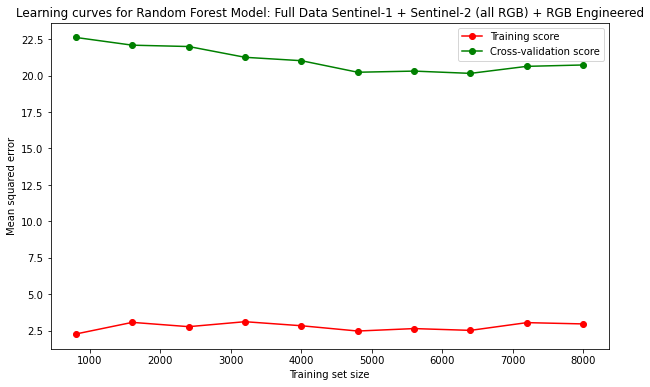

In [15]:
#### LESS DATA IN INPUT: customize the number of rows 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

# Create a random subset of samples with as many rows you want (size = 10000)
subset_idx = np.random.choice(len(X), size=10000, replace=False)
X__subset = X[subset_idx]
y__subset = y[subset_idx]

# Create an instance of the Random Forest model
rf__model = RandomForestRegressor()

# Define the range of training set sizes to use
train__sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve for the Random Forest model
train__sizes, train__scores, test__scores = learning_curve(rf__model, X__subset, y__subset, cv=5, train_sizes=train__sizes, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert the negative mean squared error scores to positive
train__scores = -train__scores
test__scores = -test__scores

# Calculate the mean and standard deviation of the cross-validated training and test scores
train__scores_mean = np.mean(train__scores, axis=1)
train__scores_std = np.std(train__scores, axis=1)
test__scores_mean = np.mean(test__scores, axis=1)
test__scores_std = np.std(test__scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train__sizes, train__scores_mean, 'o-', color='r', label='Training score')
plt.plot(train__sizes, test__scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_2_sizes, train_2_scores_mean - train_2_scores_std, train_2_scores_mean + train_2_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_2_sizes, test_2_scores_mean - test_2_scores_std, test_2_scores_mean + test_2_scores_std, alpha=0.1, color='g')
plt.title('Learning curves for Random Forest Model: Full Data Sentinel-1 + Sentinel-2 (all RGB) + RGB Engineered')
plt.xlabel('Training set size')
plt.ylabel('Mean squared error')
plt.legend(loc='best')
plt.show()

In [16]:
## Grid Search on Linear Regression and Random Forest 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameters and their possible values for Linear Regression and Random Forest
hyperparameters = {
    'LinearRegression': {'normalize': [True, False]},
    'RandomForestRegressor': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
}

# Create a dictionary of the models to be tuned
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

# Loop through the models and their hyperparameters to perform grid search
for model_name, model in models.items():
    hyperparameter_grid = hyperparameters[model_name]
    grid_search = GridSearchCV(model, hyperparameter_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model_name, "best hyperparameters:", grid_search.best_params_, "MSE:", mse, "R-squared:", r2)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   0.2s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END .....................................normalize=True; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
[CV] END ....................................normalize=False; total time=   0.1s
LinearRegression best hyperparameters: {'normalize': True} MSE: 17.176239062558647 R-squared: 0.11104281531135884
Fitting 5 folds 

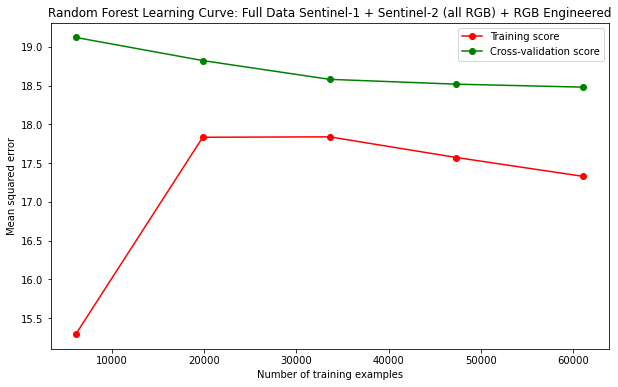

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the best hyperparameters
params = {'max_depth': 5, 'n_estimators': 300}

# Create an instance of the Random Forest model with the best hyperparameters
rf_model = RandomForestRegressor(**params)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
#plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
#plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Random Forest Learning Curve: Full Data Sentinel-1 + Sentinel-2 (all RGB) + RGB Engineered') 
plt.legend()
plt.show()

Random Forest (max_depth=5, n_estimators=300):
Mean Squared Error: 17.22
R-squared: 0.11



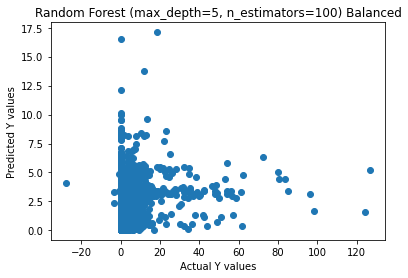

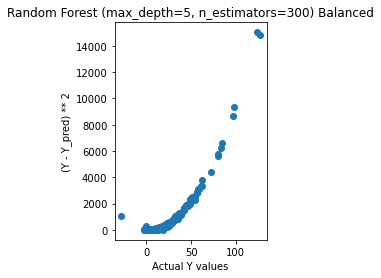

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Scale X using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Train the Random Forest Regressor model on the training data
rf = RandomForestRegressor(max_depth=5, n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf.predict(X_test)

# Evaluate the Random Forest Regressor model using mean squared error and R-squared
print("Random Forest (max_depth=5, n_estimators=300):")
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred_rf)))
print()

# Plot predicted values vs actual values for RandomForestRegressor
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Y values')
plt.ylabel('Predicted Y values')
plt.title('Random Forest (max_depth=5, n_estimators=100) Balanced')
plt.show()

# Plot (Y - Y_pred) ** 2 versus Y
plt.subplot(1, 2, 2)
plt.scatter(y_test, (y_test - y_pred_rf) ** 2)
plt.xlabel('Actual Y values')
plt.ylabel('(Y - Y_pred) ** 2')
plt.title('Random Forest (max_depth=5, n_estimators=300) Balanced')
plt.show()

My bands are  B2 (column 0), B3 (column 1),  B4 (column 2) , B5 (column 3),  B6 (column 4),  B7 (column 5), B8 (column 6), B11 (column 7), B12 (column 8). 

In [33]:
import numpy as np

# Define the positions of the red, near-infrared, blue, red-edge, and SWIR bands in the array
red_band_index = 2
nir_band_index = 6
blue_band_index = 0
rededge_band_index = 4
swir1_band_index = 7
swir2_band_index = 8

# Extract the bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
blue_band = X[:, blue_band_index]
rededge_band = X[:, rededge_band_index]
swir1_band = X[:, swir1_band_index]
swir2_band = X[:, swir2_band_index]

# Calculate NDVI and normalize
ndvi = np.zeros_like(nir_band)
mask = (nir_band + red_band) != 0
ndvi[mask] = (nir_band[mask] - red_band[mask]) / (nir_band[mask] + red_band[mask])
ndvi = np.clip(ndvi, -1, 1) # clip values outside [-1, 1] range
ndvi = (ndvi + 1) / 2 # rescale to [0, 1] range

# Create a mask for vegetation pixels
vegetation_mask = ndvi > 0.3

# Create a mask for rock pixels
rock_mask = (swir1_band > 0.15) & ~vegetation_mask

# Create a mask for building pixels
building_mask = (blue_band > 0.2) & (rededge_band > 0.25) & (swir1_band < 0.15) & (swir2_band < 0.1) & ~vegetation_mask & ~rock_mask

# Create a mask for soil pixels
soil_mask = ~(vegetation_mask | rock_mask | building_mask)


# Count the number of pixels with vegetation, rock, building, and soil values
vegetation_pixels = np.count_nonzero(vegetation_mask)
rock_pixels = np.count_nonzero(rock_mask)
building_pixels = np.count_nonzero(building_mask)
soil_pixels = np.count_nonzero(soil_mask)
total_pixels = ndvi.size

# Calculate the fraction of vegetation, rock, building, and soil pixels
fraction_vegetation = vegetation_pixels / total_pixels
fraction_rock = rock_pixels / total_pixels
fraction_building = building_pixels / total_pixels
fraction_soil = soil_pixels / total_pixels

print(f"Fraction of vegetation pixels: {fraction_vegetation:.2f}")
print(f"Fraction of rock pixels: {fraction_rock:.2f}")
print(f"Fraction of building pixels: {fraction_building:.2f}")
print(f"Fraction of soil pixels: {fraction_soil:.2f}")


Fraction of vegetation pixels: 0.50
Fraction of rock pixels: 0.24
Fraction of building pixels: 0.00
Fraction of soil pixels: 0.26


In [32]:
### USE NDBI + NDVI 

import numpy as np

# Define the positions of the red, near-infrared, blue, and SWIR1 bands in the array
red_band_index = 2
nir_band_index = 6
blue_band_index = 0
swir1_band_index = 7

# Extract the bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
blue_band = X[:, blue_band_index]
swir1_band = X[:, swir1_band_index]

# Calculate NDVI and NDBI
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndbi = (swir1_band - nir_band) / (swir1_band + nir_band)

# Create a mask for vegetation pixels
vegetation_mask = ndvi > 0.3

# Create a mask for built-up pixels
builtup_mask = ndbi > 0.2

# Calculate the fractions of vegetation and built-up pixels
num_pixels = np.prod(X.shape[:-1])
frac_vegetation = np.sum(vegetation_mask) / num_pixels
frac_builtup = np.sum(builtup_mask) / num_pixels

print(f"Fraction of vegetation pixels: {frac_vegetation:.2f}")
print(f"Fraction of built-up pixels: {frac_builtup:.2f}")


Fraction of vegetation pixels: 0.41
Fraction of built-up pixels: 0.46


In [34]:
### MORE INDICES FOR WATER, ETC... 

import numpy as np

# Define the positions of the red, near-infrared, green, blue, red-edge, SWIR1, and SWIR2 bands in the array
red_band_index = 2
nir_band_index = 6
green_band_index = 3
blue_band_index = 0
rededge_band_index = 4
swir1_band_index = 7
swir2_band_index = 8

# Extract the bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
green_band = X[:, green_band_index]
blue_band = X[:, blue_band_index]
rededge_band = X[:, rededge_band_index]
swir1_band = X[:, swir1_band_index]
swir2_band = X[:, swir2_band_index]

# Calculate NDVI, NDWI, and MNDWI
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndwi = (green_band - nir_band) / (green_band + nir_band)
mndwi = (green_band - swir1_band) / (green_band + swir1_band)

# Calculate SAVI and NDMI
l = 0.5
savi = (nir_band - red_band) / (nir_band + red_band + l) * (1 + l)
ndmi = (nir_band - swir1_band) / (nir_band + swir1_band)

# Create masks for vegetation, water, built-up, and soil pixels
vegetation_mask = ndvi > 0.3
water_mask = (ndwi > 0.2) | (mndwi > 0.1)
builtup_mask = (rededge_band > 0.25) & (swir1_band < 0.15) & (swir2_band < 0.1)
soil_mask = ~(vegetation_mask | water_mask | builtup_mask)

# Calculate the fractions of vegetation, water, built-up, and soil pixels
num_pixels = np.prod(X.shape[:-1])
frac_vegetation = np.sum(vegetation_mask) / num_pixels
frac_water = np.sum(water_mask) / num_pixels
frac_builtup = np.sum(builtup_mask) / num_pixels
frac_soil = np.sum(soil_mask) / num_pixels

print(f"Fraction of vegetation pixels: {frac_vegetation:.2f}")
print(f"Fraction of water pixels: {frac_water:.2f}")
print(f"Fraction of built-up pixels: {frac_builtup:.2f}")
print(f"Fraction of soil pixels: {frac_soil:.2f}")


Fraction of vegetation pixels: 0.41
Fraction of water pixels: 0.67
Fraction of built-up pixels: 0.21
Fraction of soil pixels: 0.07


In [35]:
import numpy as np

# Define the positions of the Sentinel-2 and Sentinel-1 bands in the array
red_band_index = 2
nir_band_index = 6
blue_band_index = 0
rededge_band_index = 4
swir1_band_index = 7
swir2_band_index = 8
vv_band_index = 9
vh_band_index = 10

# Extract the Sentinel-2 and Sentinel-1 bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
blue_band = X[:, blue_band_index]
rededge_band = X[:, rededge_band_index]
swir1_band = X[:, swir1_band_index]
swir2_band = X[:, swir2_band_index]
vv_band = X[:, vv_band_index]
vh_band = X[:, vh_band_index]

# Perform the Freeman-Durden decomposition on the Sentinel-1 bands
sigma0 = np.sqrt((vv_band**2 + vh_band**2) / 2)
sigma0_vv = vv_band**2 / sigma0
sigma0_vh = vh_band**2 / sigma0


# Calculate the vegetation fraction using the sigma-0 values of the Sentinel-1 bands
veg_frac = sigma0_vv / (sigma0_vv + sigma0_vh)
print(f"Fraction of vegetation pixels (Sentinel-1): {np.count_nonzero(veg_frac > 0.5) / len(veg_frac):.2f}")


# Create a mask for vegetation pixels using the NDVI threshold
ndvi = (nir_band - red_band) / (nir_band + red_band)
vegetation_mask = ndvi > 0.3

# Calculate the fractions of each land cover type
num_pixels = np.prod(X.shape[:-1])
frac_vegetation = np.sum(vegetation_mask) / num_pixels
frac_rocks = np.sum((swir1_band > 0.15) & ~vegetation_mask) / num_pixels
frac_builtup = np.sum((swir1_band - nir_band) / (swir1_band + nir_band) > 0.2) / num_pixels
frac_soil = np.sum(~(vegetation_mask | (swir1_band > 0.15) | ((swir1_band - nir_band) / (swir1_band + nir_band) > 0.2))) / num_pixels

print(f"Fraction of vegetation pixels: {frac_vegetation:.2f}")
print(f"Fraction of rock pixels: {frac_rocks:.2f}")
print(f"Fraction of built-up pixels: {frac_builtup:.2f}")
print(f"Fraction of soil pixels: {frac_soil:.2f}")


Fraction of vegetation pixels (Sentinel-1): 0.47
Fraction of vegetation pixels: 0.41
Fraction of rock pixels: 0.28
Fraction of built-up pixels: 0.46
Fraction of soil pixels: 0.11


In [37]:
### USE SENTINEL-1 to detect urban areas 

import numpy as np

# Define the positions of the red, near-infrared, blue, red-edge, and SWIR bands in the array
red_band_index = 2
nir_band_index = 6
swir1_band_index = 7
vv_band_index = 9
vh_band_index = 10

# Extract the bands from the array
red_band = X[:, red_band_index]
nir_band = X[:, nir_band_index]
swir1_band = X[:, swir1_band_index]
vv_band = X[:, vv_band_index]
vh_band = X[:, vh_band_index]

# Calculate the NDBI index
ndbi = (swir1_band - nir_band) / (swir1_band + nir_band)


# Calculate the urban area index using Sentinel-1 VV and VH bands
uai = 10 * np.log10(np.maximum(sigma0_vv, 1e-5) * np.maximum(sigma0_vh, 1e-5))


# Apply threshold values to obtain binary masks
ndbi_mask = ndbi > 0.2
uai_mask = uai > 2

# Combine the masks to obtain the overall urban mask
urban_mask = ndbi_mask | uai_mask

# Calculate the fraction of urban pixels
frac_urban = np.count_nonzero(urban_mask) / urban_mask.size

print(f"Fraction of urban pixels: {frac_urban:.2f}")


Fraction of urban pixels: 0.53
